In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## What we're going to cover

We're going to apply the PyTorch Workflow we've been learning in the past couple of sections to computer vision.

![a PyTorch workflow with a computer vision focus](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-pytorch-computer-vision-workflow.png)

Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **0. Computer vision libraries in PyTorch** | PyTorch has a bunch of built-in helpful computer vision libraries, let's check them out.  |
| **1. Load data** | To practice computer vision, we'll start with some images of different pieces of clothing from [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). |
| **2. Prepare data** | We've got some images, let's load them in with a [PyTorch `DataLoader`](https://pytorch.org/docs/stable/data.html) so we can use them with our training loop. |
| **3. Model 0: Building a baseline model** | Here we'll create a multi-class classification model to learn patterns in the data, we'll also choose a **loss function**, **optimizer** and build a **training loop**. | 
| **4. Making predictions and evaluting model 0** | Let's make some predictions with our baseline model and evaluate them. |
| **5. Setup device agnostic code for future models** | It's best practice to write device-agnostic code, so let's set it up. |
| **6. Model 1: Adding non-linearity** | Experimenting is a large part of machine learning, let's try and improve upon our baseline model by adding non-linear layers. |
| **7. Model 2: Convolutional Neural Network (CNN)** | Time to get computer vision specific and introduce the powerful convolutional neural network architecture. |
| **8. Comparing our models** | We've built three different models, let's compare them. |
| **9. Evaluating our best model** | Let's make some predictons on random images and evaluate our best model. |
| **10. Making a confusion matrix** | A confusion matrix is a great way to evaluate a classification model, let's see how we can make one. |
| **11. Saving and loading the best performing model** | Since we might want to use our model for later, let's save it and make sure it loads back in correctly. |

## 0. Computer vision libraries in PyTorch

Before we get started writing code, let's talk about some PyTorch computer vision libraries you should be aware of.

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torchvision`](https://pytorch.org/vision/stable/index.html) | Contains datasets, model architectures and image transformations often used for computer vision problems. |
| [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) | Here you'll find many example computer vision datasets for a range of problems from image classification, object detection, image captioning, video classification and more. It also contains [a series of base classes for making custom datasets](https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets). |
| [`torchvision.models`](https://pytorch.org/vision/stable/models.html) | This module contains well-performing and commonly used computer vision model architectures implemented in PyTorch, you can use these with your own problems. | 
| [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) | Often images need to be transformed (turned into numbers/processed/augmented) before being used with a model, common image transformations are found here. | 
| [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) | Base dataset class for PyTorch.  | 
| [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#module-torch.utils.data) | Creates a Python iterable over a dataset (created with `torch.utils.data.Dataset`). |

> **Note:** The `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` classes aren't only for computer vision in PyTorch, they are capable of dealing with many different types of data.

Now we've covered some of the most important PyTorch computer vision libraries, let's import the relevant dependencies.


In [2]:
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.transforms import ToTensor

print(torch.__version__)
print(torchvision.__version__)

2.3.0+cu121
0.18.0+cu121


# GETTING DATA READY

In [3]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

In [4]:
class_names=train_data.classes
"train data have",len(train_data), len(test_data),class_names

('train data have',
 60000,
 10000,
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

In [5]:
class_to_idx=train_data.class_to_idx# class to index mapping in training data
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [6]:
train_data.targets# labels of training data

tensor([9, 0, 0,  ..., 3, 0, 5])

In [7]:
#first image
image,label=train_data[0]# it give image tensor and label
image.shape,label#label 9 is ankle boot

(torch.Size([1, 28, 28]), 9)

colour channel is 1 for greyscale

## ploting image

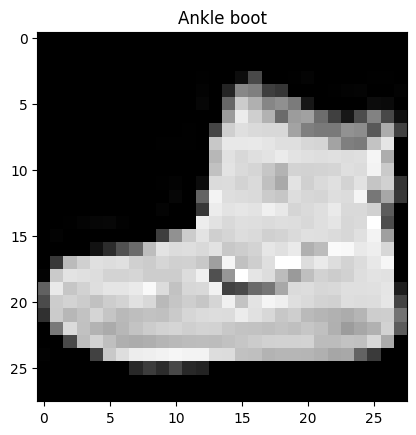

In [8]:
#plotting image
plt.imshow(image.squeeze(),cmap='gray')#squeeze is used to remove extra dimension
#imshow req 28x28 image but we have 1x28x28 image so we need to remove extra dimension
plt.title(class_names[label])
plt.show()

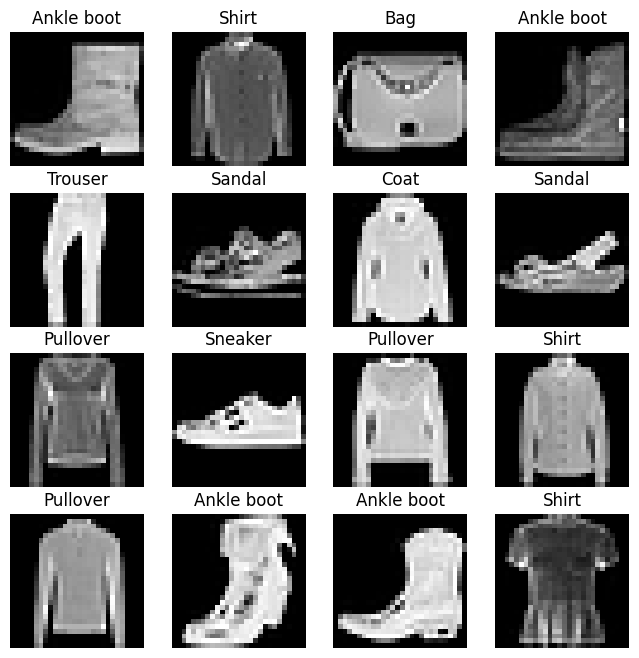

In [9]:
# plot more images
torch.manual_seed(42)
figure = plt.figure(figsize=(8, 8))
cols, rows = 4,4# 5 cols and 4 rows of images
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()#size
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(class_names[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## dataloader

`32` images batch sizee we need
it will be more efficient

In [10]:
## prepare data for training
from torch.utils.data import DataLoader

# Create batchsize hyperparameter
BATCH_SIZE=32

# datases into iterable 
train_dataloader = DataLoader(train_data,# we have 60000 images data
                           batch_size=BATCH_SIZE, #devide into 32 batch size 60000/32=1875
                           shuffle=True)# suffle data and then create batch

test_dataloader = DataLoader(test_data,
                            batch_size=BATCH_SIZE, 
                            shuffle=False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x788b104d2b30>,
 <torch.utils.data.dataloader.DataLoader at 0x788b104d3ee0>)

we have craeted batches of 32

In [11]:
print("Number of training batches",len(train_dataloader),"of size",BATCH_SIZE)#training batches
print("Number of testing batches",len(test_dataloader),"of size",BATCH_SIZE)

Number of training batches 1875 of size 32
Number of testing batches 313 of size 32


## checking dataloader


In [12]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))# get first batch
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


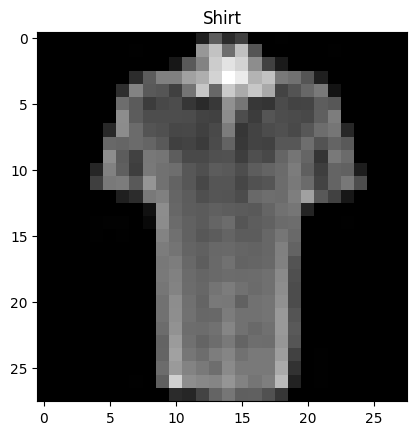

In [13]:
# show a sample batch
torch.manual_seed(42)
random_idx = torch.randint(len(train_features_batch), size=(1,)).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.title(class_names[label.item()])
plt.imshow(img.squeeze(), cmap="gray")
for images, labels in train_dataloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

# model 0: BASELINE MODEL


## flaten layer

In [14]:
# create a flaten layer
""" it create the flatten layer which will take 28x28 image and convert it into 784x1 image"""
flatten_model = nn.Flatten()
x=train_features_batch[0]# get first image of first batch
print("Original shape:", x.shape)
x = flatten_model(x)
print("Flattened shape:", x.shape)

Original shape: torch.Size([1, 28, 28])
Flattened shape: torch.Size([1, 784])


## model

In [15]:
class fashion_mnist_V0(nn.Module):
    def __init__(self,
                 input_shapes: int,
                 hidden_units: int,
                 output_units: int):
        super().__init__()  # Correct usage of super()
        self.layer_stack=nn.Sequential(
            nn.Flatten(),# create 28x28 image to 784x1 image
             nn.Linear(in_features=input_shapes, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_units)   
        )
    def forward(self,x):
        x=self.layer_stack(x)
        return x

In [16]:
torch.manual_seed(42)

model_fashion_V0=fashion_mnist_V0(input_shapes=784,
                                        hidden_units=10,
                                        output_units=10)
model_fashion_V0


fashion_mnist_V0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

## optimizer and loss function

In [17]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(params=model_fashion_V0.parameters(), lr=0.1)

downloading helper function which we will need some fxn so we dont have to write again

In [18]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [19]:
# Import helper functions from helper_functions.py
import helper_functions as hf
from helper_functions import accuracy_fn
accuracy_fn

<function helper_functions.accuracy_fn(y_true, y_pred)>

### time performance

In [20]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    print(f"Training time: {end - start}", "seconds","on device",device)
start=timer()
# Training loop or some code
end=timer()
print_train_time(start,end,device="cpu")


Training time: 7.387017831206322e-06 seconds on device cpu


## training loop

In [21]:
train_dataloader

In [22]:
from tqdm.auto import tqdm
#set seed and timer
torch.manual_seed(42)
start_time_on_cpu=timer()

epochs=3

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n-------------------------------")
    train_loss=0
    for batch, (X,y) in enumerate(train_dataloader):# enumerate give index of batch and data and data is tuple of image and label
        # X=X.to(device)
        # y=y.to(device)
        model_fashion_V0.train()
        y_pred=model_fashion_V0(X)

        #loss of batch
        loss=loss_fn(y_pred,y)
        train_loss+=loss#adding all batch loss

        #optimizer zero grad
        optimizer.zero_grad()
        
        #loss backward
        loss.backward()

        #optimizer step
        optimizer.step()
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
    train_loss/=len(train_dataloader)# average loss


    #testing
    test_loss,test_acc=0,0
    model_fashion_V0.eval()
    with torch.no_grad():
        for X_test,y_test in test_dataloader:

            #predicting test
            y_pred=model_fashion_V0(X_test)
            #loss of test
            loss=loss_fn(y_pred,y_test)
            test_loss+=loss.item()

            test_acc+=accuracy_fn(y_test,y_pred= y_pred.argmax(dim=1))

    test_loss/=len(test_dataloader) # for average loss
    test_acc/=len(test_dataloader)# for average accuracy
    print(f"Epoch {epoch}|Training loss: {train_loss} | Testing loss: {test_loss},| Testing accuracy: {test_acc}")
end_time_on_cpu=timer()
print_train_time(start_time_on_cpu,end_time_on_cpu,device=str(next(model_fashion_V0.parameters()).device))


/home/karansingh/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:05<00:11,  5.92s/it]

Epoch 0|Training loss: 0.5903892517089844 | Testing loss: 0.5095351154145341,| Testing accuracy: 82.03873801916933
Epoch 1
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:11<00:05,  5.48s/it]

Epoch 1|Training loss: 0.4763319790363312 | Testing loss: 0.47988997228419816,| Testing accuracy: 83.19688498402556
Epoch 2
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:13<00:00,  4.55s/it]

Epoch 2|Training loss: 0.4550333023071289 | Testing loss: 0.4766388939687619,| Testing accuracy: 83.42651757188499
Training time: 13.653668518003542 seconds on device cpu


In [23]:
!nvidia-smi

Thu May 16 05:27:07 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 ...    Off |   00000000:01:00.0  On |                  N/A |
|  0%   48C    P5             24W /  125W |     621MiB /   6144MiB |     33%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## prediction through our model

In [24]:
def eval_model(model : torch.nn.modules,# model name
               data_loader: torch.utils.data.DataLoader,# data loader
               loss_fn: torch.nn.modules,# loss function
               accuracy_fn,# accuracy function
               device: torch.device=torch.device("cpu")):
    model.eval()
    loss=0
    acc=0
    with torch.inference_mode():
        for X,y in data_loader:
            X=X.to(device)
            y=y.to(device)
            y_pred=model(X)
            loss+=loss_fn(y_pred,y)
            acc+=accuracy_fn(y# y_true
                             ,y_pred.argmax(dim=1))
        loss/=len(data_loader)
        acc/=len(data_loader)
    return {"model name":model.__class__.__name__,#loss in tensor so we need to convert into float,
            "loss":loss.item(),
            "accuracy":acc}


In [25]:
model_fashion_V0_results=eval_model(model=model_fashion_V0,
                                    data_loader=test_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn)
model_fashion_V0_results

{'model name': 'fashion_mnist_V0',
 'loss': 0.4766390025615692,
 'accuracy': 83.42651757188499}

## running on gpu


In [26]:

class fashion_mnist_V1(nn.Module):
    def __init__(self,
                 input_shapes: int,
                 hidden_units: int,
                 output_units: int):
        super().__init__()  # Correct usage of super()
        self.layer_stack=nn.Sequential(
            nn.Flatten(),# create 28x28 image to 784x1 image
             nn.Linear(in_features=input_shapes, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_units)   
        )
    def forward(self,x):
        x=self.layer_stack(x)
        return x
torch.manual_seed(42)
model_fashion_v1=fashion_mnist_V1(input_shapes=784,
                                        hidden_units=10,
                                        output_units=10).to(device)
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer_v2 = torch.optim.SGD(params=model_fashion_v1.parameters(), lr=0.1)


gpu loop


In [27]:
from tqdm.auto import tqdm
#set seed and timer
torch.manual_seed(42)
start_time_on_cpu=timer()

epochs=3

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n-------------------------------")
    train_loss=0
    for batch, (X,y) in enumerate(train_dataloader):# enumerate give index of batch and data and data is tuple of image and label
        # X=X.to(device)
        # y=y.to(device)
        model_fashion_v1.train()
        y_pred=model_fashion_v1(X.to(device))

        #loss of batch
        loss=loss_fn(y_pred,y.to(device))
        train_loss+=loss#adding all batch loss

        #optimizer zero grad
        optimizer_v2.zero_grad()
        
        #loss backward
        loss.backward()

        #optimizer step
        optimizer_v2.step()
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
    train_loss/=len(train_dataloader)# average loss


    #testing
    test_loss,test_acc=0,0
    model_fashion_v1.eval()
    with torch.inference_mode():
        for X_test,y_test in test_dataloader:

            #predicting test
            y_pred=model_fashion_v1(X_test.to(device))
            #loss of test
            loss=loss_fn(y_pred,y_test.to(device))
            test_loss+=loss.item()

            test_acc+=accuracy_fn(y_test.to(device),y_pred= y_pred.argmax(dim=1))

    test_loss/=len(test_dataloader) # for average loss
    test_acc/=len(test_dataloader)# for average accuracy
    print(f"Epoch {epoch}|Training loss: {train_loss} | Testing loss: {test_loss},| Testing accuracy: {test_acc}")
end_time_on_cpu=timer()
print_train_time(start_time_on_cpu,end_time_on_cpu,device=str(next(model_fashion_v1.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:02<00:05,  2.70s/it]

Epoch 0|Training loss: 0.5903893113136292 | Testing loss: 0.5095350884686644,| Testing accuracy: 82.03873801916933
Epoch 1
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:05<00:02,  2.63s/it]

Epoch 1|Training loss: 0.4763319492340088 | Testing loss: 0.4798899779971034,| Testing accuracy: 83.19688498402556
Epoch 2
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:07<00:00,  2.66s/it]

Epoch 2|Training loss: 0.4550333023071289 | Testing loss: 0.4766388906838414,| Testing accuracy: 83.42651757188499
Training time: 7.981043763982598 seconds on device cuda:0


In [28]:
X_test.device

device(type='cpu')

### train step

In [29]:
# def train_step
def train_step(model: torch.nn.modules,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.modules,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    model.train()
    train_loss,train_acc=0,0
    for X,y in data_loader:
        X = X.to(device)
        y = y.to(device)
        y_pred=model(X)

        #loss of batch
        loss=loss_fn(y_pred,y)
        train_loss += loss#adding all batch loss

        #optimizer zero grad
        optimizer.zero_grad()
        
        #loss backward
        loss.backward()

        #optimizer step
        optimizer.step()
        train_loss += loss.item()

        train_acc+=accuracy_fn(y,y_pred= y_pred.argmax(dim=1))
    train_loss/=len(data_loader)# average loss
    train_acc/=len(data_loader)# average accuracy
    return train_loss,train_acc

### test step

In [30]:
# test_step
def test_step(model: torch.nn.modules,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.modules,
               accuracy_fn,
               device: torch.device = device):
    model.eval()
    test_loss,test_acc=0,0
    with torch.inference_mode():
        for X,y in data_loader:
            X = X.to(device)
            y = y.to(device)
            y_pred=model(X)
            loss=loss_fn(y_pred,y)
            test_loss+=loss.item()
            acc=accuracy_fn(y,y_pred= y_pred.argmax(dim=1))
            test_acc+=acc
        test_loss/=len(data_loader)
        test_acc/=len(data_loader)
    return test_loss,test_acc

In [31]:
start_time_on_gpu=timer()
epochs=3
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n-------------------------------")
    train_loss,train_acc=train_step(model=model_fashion_v1,
                                    data_loader=train_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer_v2,
                                    accuracy_fn=accuracy_fn,
                                    device=device)
    test_loss,test_acc=test_step(model=model_fashion_v1,
                                 data_loader=test_dataloader,
                                 loss_fn=loss_fn,
                                 accuracy_fn=accuracy_fn,
                                 device=device)
    print(f"Epoch {epoch}|Training loss: {train_loss} | Testing loss: {test_loss},| Testing accuracy: {test_acc}")
end_time_on_gpu=timer()
print_train_time(start_time_on_gpu,end_time_on_gpu,device=str(next(model_fashion_v1.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
-------------------------------


 33%|███▎      | 1/3 [00:02<00:05,  2.83s/it]

Epoch 0|Training loss: 0.8850244879722595 | Testing loss: 0.46305625512005805,| Testing accuracy: 83.74600638977635
Epoch 1
-------------------------------


 67%|██████▋   | 2/3 [00:05<00:02,  2.80s/it]

Epoch 1|Training loss: 0.8716315627098083 | Testing loss: 0.4686939125053418,| Testing accuracy: 83.2667731629393
Epoch 2
-------------------------------


100%|██████████| 3/3 [00:08<00:00,  2.85s/it]

Epoch 2|Training loss: 0.8582940101623535 | Testing loss: 0.45892010076929585,| Testing accuracy: 83.6361821086262
Training time: 8.539345828001387 seconds on device cuda:0


In [32]:
model_fashion_V1_results=eval_model(model=model_fashion_v1,
                                    data_loader=test_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device=device)
model_fashion_V1_results

{'model name': 'fashion_mnist_V1',
 'loss': 0.4589199721813202,
 'accuracy': 83.6361821086262}

# CNN model

It follows the typical structure of a convolutional neural network:

`Input layer -> [Convolutional layer -> activation layer -> pooling layer] -> Output layer`


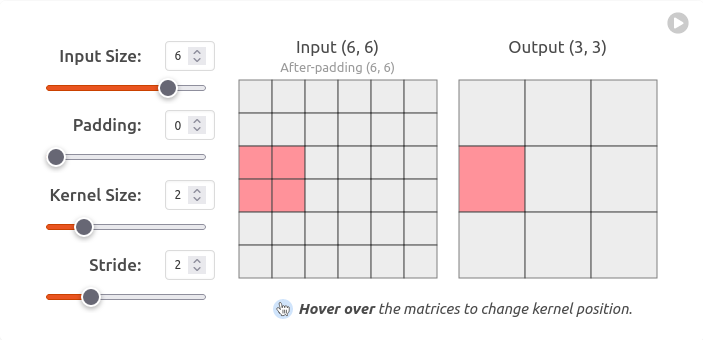
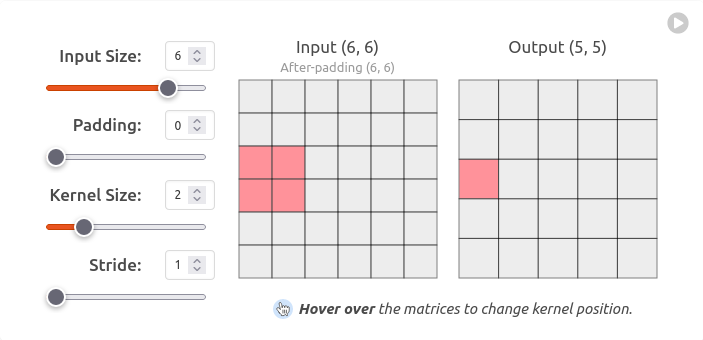

`kernel `: kernel is matrix multiply with same pixel matrix

` pading` : boundary

` stride ` : how much kernal moves

In [33]:
class fashion_mnist_CNN_V0(nn.Module):# 3rd model a CNN model
    def __init__(self,
                 input_channels: int,
                 hidden_units: int,
                 output_units: int):
        super().__init__()  # Correct usage of super()
        self.layer_stack=nn.Sequential(
            nn.Conv2d(in_channels=input_channels,
                       out_channels=hidden_units, 
                       kernel_size=3,
                       stride=1,
                       padding=1
                       ),# 1st layer
            # nn.MaxPool2d(kernel_size=2, stride=2),# 2nd layer
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3,stride=1,padding=1),# 3rd layer
            nn.MaxPool2d(kernel_size=2, stride=2),# 4th layer
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2) )      
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*7*7, output_units)
        )
    def forward(self,x):
        x=self.layer_stack(x)
        x=self.block_2(x)
        x=self.classifier(x)
        return x

In [34]:
torch.manual_seed(42)
model_fashion_CNN_0=fashion_mnist_CNN_V0(input_channels=1,# we have 1 channel image bcs we have gray scale image
                                        hidden_units=10,
                                        output_units=10).to(device)#we have 10 classes
model_fashion_CNN_0

fashion_mnist_CNN_V0(
  (layer_stack): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## nn.conv2d

In [35]:
# random image
image,label=train_data[0]
image.shape,label

(torch.Size([1, 28, 28]), 9)

In [36]:
# create a single conv2d layer
conv1_layer = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding=1).to(device)
conv1_layer


Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [37]:
conv1_layer_Output = conv1_layer(image.to(device))
conv1_layer_Output.shape,conv1_layer_Output[1]

(torch.Size([10, 28, 28]),
 tensor([[ 0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,
           0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,
           0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,
           0.2517,  0.2517,  0.2517,  0.2517],
         [ 0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,
           0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,
           0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,
           0.2517,  0.2517,  0.2517,  0.2517],
         [ 0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,
           0.2517,  0.2517,  0.2517,  0.2518,  0.2520,  0.2525,  0.2520,  0.2565,
           0.2811,  0.3070,  0.2518,  0.2521,  0.2536,  0.2548,  0.2517,  0.2517,
           0.2518,  0.2520,  0.2528,  0.2525],
         [ 0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,  0.2517,
           0

## conv2d layer output image

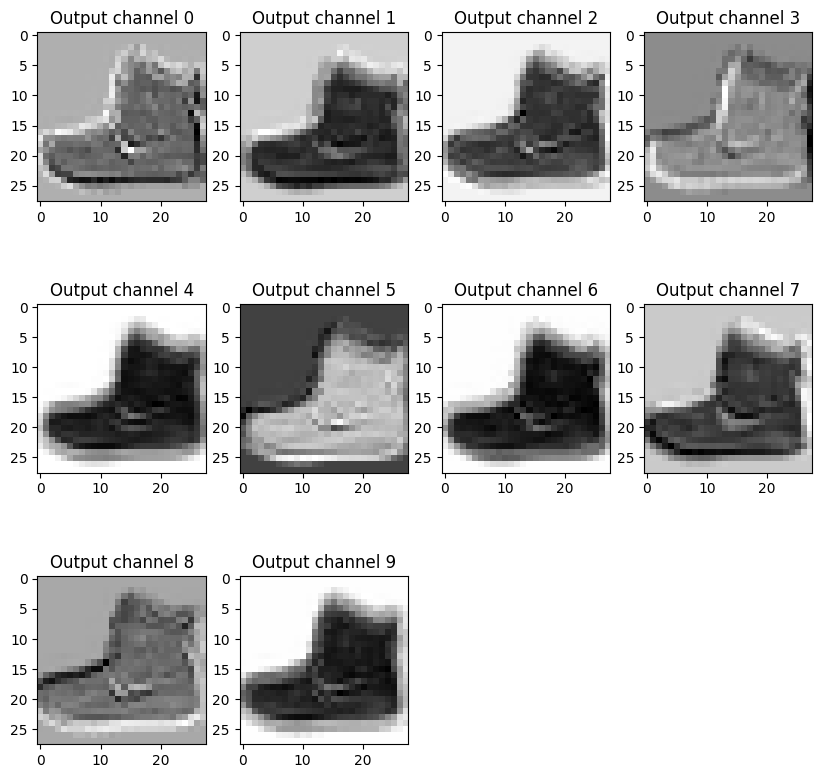

In [38]:
#create image all 10 output
figure=plt.figure(figsize=(10,10))
for i in range(10):
    figure.add_subplot(3,4,i+1)
    plt.title(f"Output channel {i}")
    plt.imshow(conv1_layer_Output[i].detach().cpu().numpy(),cmap="gray")

## maXPLOT

In [39]:
# MAXPLOT LAYER
maxpool_layer = nn.MaxPool2d(kernel_size=2, stride=2).to(device)
"""MAXPLOT LAYER take 10x28x28 image and convert it into 10x14x14 image
    MAXPLOT WILL TAKE 2x2 image and take max value from it and create 14x14 image"""
maxpool_layer_output = maxpool_layer(conv1_layer_Output)
maxpool_layer_output.shape

torch.Size([10, 14, 14])

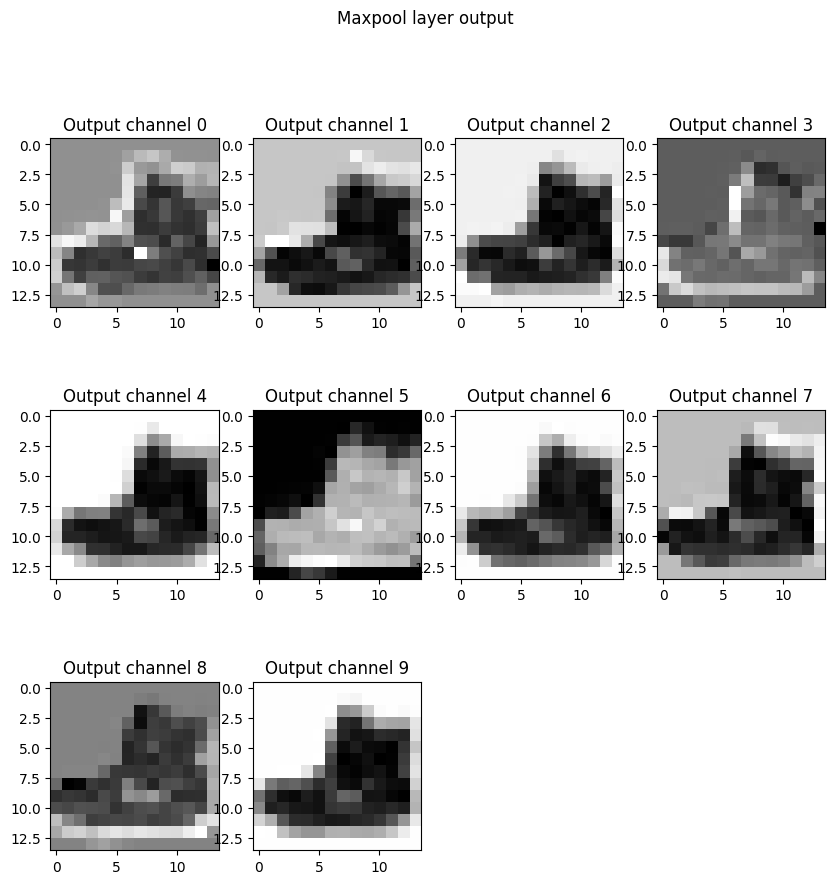

In [40]:
# create image all 10 output
figure=plt.figure(figsize=(10,10))
figure.suptitle("Maxpool layer output")
for i in range(10):
    figure.add_subplot(3,4,i+1)
    plt.title(f"Output channel {i}")
    plt.imshow(maxpool_layer_output[i].detach().cpu().numpy(),cmap="gray")

plt.show()